In [2]:
import pandas as pd, numpy as np, pymc as pm

ModuleNotFoundError: No module named 'pymc'

In [2]:
import matplotlib.pyplot as plt

- pull in age x sex structure for a specific block

- pull in decennial hh sizes
- assign arbitrary hhids, relationships

- run mcmc

# Test out household structure assignment with mcmc

Objective: given a synthetic dataset that contains, for each individual, their census block, precise age, sex, and precise race, assign a realistic household structure (wrt household ids and relationships to head of household) using distributions from the 2010 decennial.

## pull in reference data

This is synthetic data; it was generated using the 2010 decennial and the 2018 acs (should switch to 2010)

It has fairly accurate age, sex, and race distribution for each census block. The relationship and ethnicity (hispanic binary) columns are bad, because they are informed only by the state-level distribution of each var from the ACS. We will scrap those relationship assigments and reassign them using MCMC and the block-level decennial data. The inaccuracy of the ethnicity still needs to be addressed.

In [11]:
## pull in df to fit to from decennial
input_dir = '/home/j/temp/beatrixh/sim_science/decennial_census_2010/'
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']
household_sizes = ['P02800' + ('00' + str(i))[-2:] for i in np.arange(1,17)]
relations_present = ['P02900' + ('00' + str(i))[-2:] for i in np.arange(1,29)]
household_type = ['P03000' + ('00' + str(i))[-2:] for i in np.arange(1,14)]

In [8]:
# this is the 2010 decennial for a single block in ravenna
ravenna = pd.read_csv('/home/j/temp/beatrixh/sim_science/outputs/example_hh_structure_assignment/decennial_ravenna_07_20_2020.csv')

In [9]:
## pull in age-sex structure for a single block
df = pd.read_csv('/home/j/temp/beatrixh/sim_science/outputs/example_hh_structure_assignment/ravenna_07_14_2020.csv')
df = df.drop(columns='relationship')

In [12]:
#relationship to head of hh
relp_labels = ['total', 'in_households', 'in_family_households',
               'householders_family', 'male_householder_family', 
               'female_householder_family', 'spouse', 'biological_child',
               'adopted_child', 'stepchild', 'grandchild', 'sibling', 
               'parent', 'parent_in_law', 'child_in_law', 
               'other_relatives', 'nonrelatives', 
               'in_nonfamily_households', 
               'male_householder_nonfamily','male_householder_nonfamily_alone','male_householder_nonfamily_not_alone', 
               'female_householder_nonfamily', 'female_householder_nonfamily_alone','female_householder_nonfamily_not_alone', 
               'nonrelatives_nonfamily',
               'in_gq','gq_inst','gq_noninst']

ravenna_relps = ravenna[relations_present].melt(value_name = 'counts', var_name = 'relp')
ravenna_relps['decennial_relp'] = relp_labels

#these will be onto and mutually exclusive, but not 1:1 or defined on the entire domain
decennial_acs_relp_dict = {'householders_family':0,
                           'male_householder_nonfamily':0,
                           'female_householder_nonfamily':0,
                           'spouse':1,
                          'biological_child':2,
                          'adopted_child':3,
                          'stepchild':4,
                          'sibling':5,
                          'parent':6,
                          'grandchild':7,
                          'parent_in_law':8,
                          'child_in_law':9,
                          'other_relatives':10,
                          'nonrelatives':15, #refine this 
                          'nonrelatives_nonfamily':15, #refine this
                          'gq_inst':16,
                          'gq_noninst':17} #same-sex spouses were mapped to nonrelatives

ravenna_relps['relp_id'] = ravenna_relps.decennial_relp.map(decennial_acs_relp_dict)
ravenna_relps = ravenna_relps[ravenna_relps.relp_id.notna()]
# ravenna_relps = ravenna_relps.drop(columns=['relp','decennial_relp'])
# ravenna_relps = ravenna_relps.groupby('relp_id').sum().reset_index()

In [13]:
## household type
hh_type_labels = ['total','in_family_hh',
                  'in_husband_wife_family',
                  'in_other_family','in_male_head_no_wife',
                  'in_female_head_no_husband','in_non_family',
                  'non_family_male_head','non_family_male_head_alone',
                  'non_family_male_head_not_alone',
                  'non_family_female_head','non_family_female_head_alone',
                  'non_family_female_head_not_alone']

ravenna_hh_types = ravenna[household_type].melt(value_name = 'counts', var_name = 'hh_type')
ravenna_hh_types['hh_type_label'] = hh_type_labels

In [14]:
## household ids
ravenna_hhs = ravenna[household_sizes].melt(value_name = 'counts', var_name = 'hh_size')

## map census vars to household sizes
d = {}
d.update({i:int(i[-1])-1 for i in ravenna.columns[8:14]})
d.update({i:int(i[-1])+1 for i in ravenna.columns[15:]})

ravenna_hhs['hh_size'] = ravenna_hhs.hh_size.map(d)
ravenna_hhs = ravenna_hhs[ravenna_hhs.hh_size.notna()]
ravenna_hhs = ravenna_hhs.groupby('hh_size').sum().reset_index()

In [15]:
n_households = ravenna_hhs['counts'].sum()
n_sims = df.pweight.sum()

print(f'''n_households: {n_households}
n_simulants: {n_sims}''')

n_households: 24
n_simulants: 65


## checkout trace 

In [3]:
trace_dir = '/home/j/temp/beatrixh/sim_science/outputs/example_hh_structure_assignment/example_mcmc_ravenna/'

In [44]:
%%time

relp_trace_full = np.genfromtxt(trace_dir + 'relp_trace_job_9_iter_49.csv', delimiter=',')
hhid_trace_full = np.genfromtxt(trace_dir + 'hhid_trace_job_9_iter_49.csv', delimiter=',')
family_hh_trace_full = np.genfromtxt(trace_dir + 'family_hh_trace_job_9_iter_49.csv', delimiter=',')

CPU times: user 5min 33s, sys: 51.2 s, total: 6min 24s
Wall time: 6min 26s


In [48]:
relp_trace = relp_trace_full[1::50]
hhid_trace = hhid_trace_full[1::50]
family_hh_trace = family_hh_trace_full[1::50]

In [49]:
%%time
hh_head_count_trace = [sum([1 if i==0 else 0 for i in j]) for j in relp_trace]

CPU times: user 836 ms, sys: 16 ms, total: 852 ms
Wall time: 849 ms


In [50]:
%%time
spouse_count_trace = [sum([1 if i==1 else 0 for i in j]) for j in relp_trace]

CPU times: user 867 ms, sys: 37 ms, total: 904 ms
Wall time: 900 ms


In [51]:
def eval_hh_dist(hhid, target=ravenna_hhs):
    sim_hh_sizes = pd.DataFrame({'hhids':hhid}).hhids.value_counts().value_counts()
    sim_hh_sizes = pd.DataFrame(sim_hh_sizes).reset_index().rename(columns={'index':'hh_size','hhids':'sim_counts'})
    
    #compare to target distribution
    compare = sim_hh_sizes.merge(target, on = 'hh_size', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return compare.abs_diff.sum()

In [52]:
%%time
hh_dist_trace_full = [eval_hh_dist(i) for i in hhid_trace]

CPU times: user 4min 48s, sys: 1.28 s, total: 4min 49s
Wall time: 4min 49s


In [53]:
def eval_relp_dist(relp, target = ravenna_relps):
    #count relp distribution in sim data
    sim_relps = pd.DataFrame({'relps':relp}).relps.value_counts()
    sim_relps = pd.DataFrame(sim_relps).reset_index().rename(columns={'index':'relp_id','relps':'sim_counts'})

    #compare to target distribution
    compare = sim_relps.merge(target, on='relp_id', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return compare.abs_diff.sum()

In [54]:
%%time
relp_dist_error_trace = [eval_relp_dist(i) for i in relp_trace]

CPU times: user 5min 42s, sys: 1.42 s, total: 5min 43s
Wall time: 5min 43s


In [56]:
def checkout_one_head_per_hh_soft_constraint(relp, hhid):
    #count hh_heads
    hh_heads = [1 if i==0 else 0 for i in relp]
    
    #enumerate per hhid
    heads_per_hh = pd.DataFrame({'hhid':hhid,'hh_head_count':hh_heads})
    heads_per_hh = heads_per_hh.groupby('hhid').sum()
    
    return heads_per_hh.sort_values('hhid')

In [57]:
def eval_one_head_per_hh(relp, hhid):
    df = checkout_one_head_per_hh_soft_constraint(relp, hhid)
    df['hh_head_count_error'] = np.abs(df['hh_head_count'] - 1)
    
    return df.hh_head_count_error.sum()

In [58]:
heads_per_hh_error = [eval_one_head_per_hh(i, j) for (i,j) in zip(relp_trace,hhid_trace)]

In [59]:
target_family_hh = ravenna_hh_types[ravenna_hh_types.hh_type_label=='in_family_hh'].counts.values[0]
family_hh_error = [target_family_hh - sum(i) for i in family_hh_trace]

In [60]:
def eval_spouse_assignments(relp, hhid, family_hh):
    # pull all vars
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    non_fam = df[df.family_hh==0]
    
    #enumerate extra spouses in family hhs with >1 spouse
    fam.loc[:,'spouses_count'] = [1 if i==1 else 0 for i in fam.relp]
    fam = fam.groupby('hhid').sum()
    extra_spouses_fam = sum([i-1 if i>1 else 0 for i in fam.spouses_count])
    
    #enumerate extra spouses in non family hhs (should this be penalized more?)
    extra_spouses_nonfam = sum([1 if i==1 else 0 for i in non_fam.relp])
    
    return extra_spouses_fam + extra_spouses_nonfam

In [61]:
spouse_assign_error = [eval_spouse_assignments(i, j, k) for (i,j,k) in zip(relp_trace, hhid_trace, family_hh_trace)]

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [62]:
def eval_nonrelative_assign(relp, hhid, family_hh):
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[(df.family_hh==1) & (df.relp==15)].shape[0]
    non_fam = df[(df.family_hh==0) & (~df.relp.isin([0,15]))].shape[0]

    return (fam + non_fam)

In [63]:
nonrel_assign_error = [eval_nonrelative_assign(i, j, k) for (i,j,k) in zip(relp_trace, hhid_trace, family_hh_trace)]

In [66]:
def eval_single_hh(hhid, family_hh):
    df = pd.DataFrame({'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    fam['pweight'] = 1

    # see how many people in each hh
    hhs = fam.groupby('hhid').sum()

    return sum([1 if i==1 else 0 for i in hhs.pweight])

In [67]:
single_hh_assign_error = [eval_single_hh(i, j) for (i,j) in zip(hhid_trace, family_hh_trace)]

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
n = 9

fig, axs = plt.subplots(n, sharex=True, gridspec_kw={'hspace': 0}, figsize = (8,4*n))

# fig.suptitle('Trace')

k = 0

y = hh_dist_trace_full
x = np.arange(len(hh_dist_trace_full))

axs[k].plot(x,y)
axs[k].set_ylabel('hh size distribution error')
k += 1

target_spouses = ravenna_relps[ravenna_relps.relp_id==1].counts.values[0]
y = [np.abs(target_spouses - i) for i in spouse_count_trace]
x = np.arange(len(spouse_count_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('error in total number of spouses')
k += 1

target_heads = ravenna_relps[ravenna_relps.relp_id<1].counts.sum()
y = [np.abs(target_heads - i) for i in hh_head_count_trace]
x = np.arange(len(hh_head_count_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('total count of hh heads error')
k += 1

y = np.abs(relp_dist_error_trace)
x = np.arange(len(relp_dist_error_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('error in relationship to head distribution')
k += 1

y = heads_per_hh_error
x = np.arange(len(heads_per_hh_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of misassigned hh heads')
k += 1

y = np.abs(family_hh_error)
x = np.arange(len(family_hh_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of people in family hhs error')
k += 1

y = np.abs(spouse_assign_error)
x = np.arange(len(spouse_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of spouses assigned to incorrect hhs')
k += 1

y = np.abs(nonrel_assign_error)
x = np.arange(len(nonrel_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('missasigned nonfamily nonrelatives')
k += 1

y = np.abs(single_hh_assign_error)
x = np.arange(len(single_hh_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('single households misassigned as family hhs')
k += 1

plt.title("Trace: mcmc performance (every 50th draw)")
for i in range(n):
    axs[i].grid()
    axs[i].set_ylim(ymin=0)

plt.show()

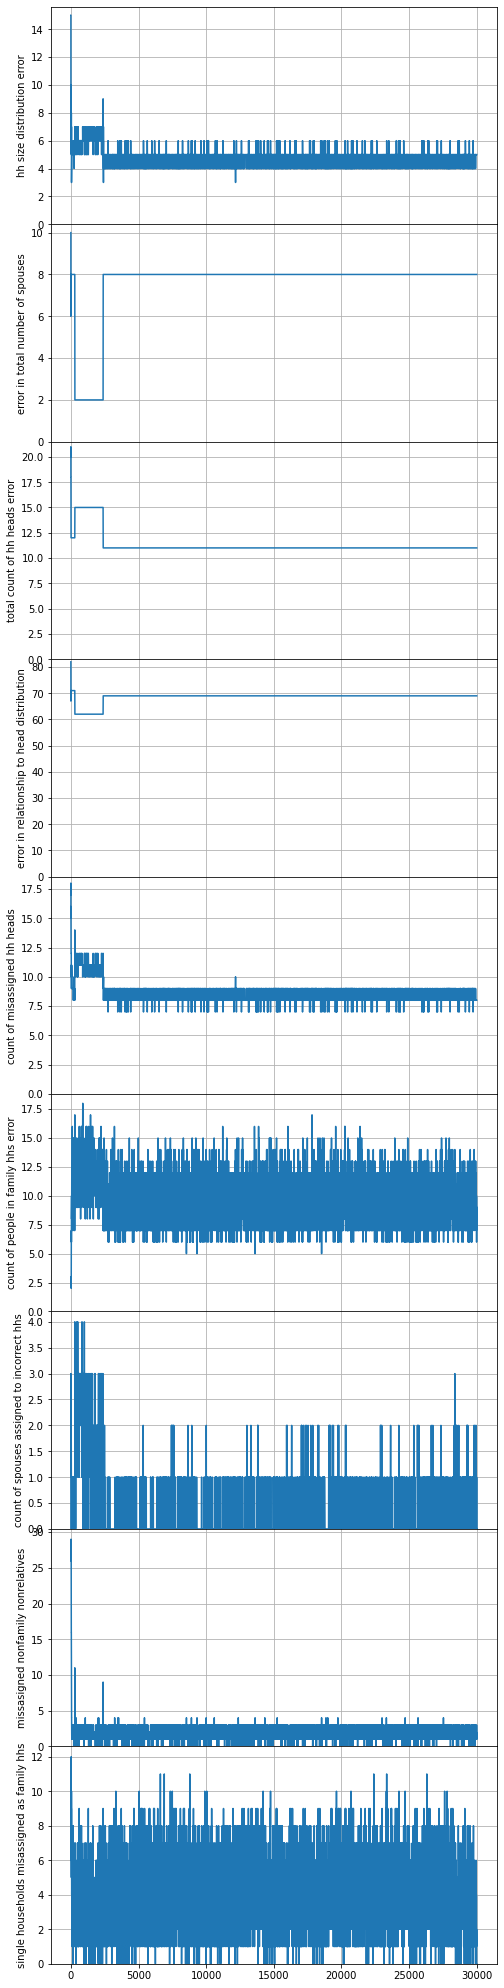

In [68]:
# n = 9

# fig, axs = plt.subplots(n, sharex=True, gridspec_kw={'hspace': 0}, figsize = (8,4*n))

# # fig.suptitle('Trace')

# k = 0

# y = hh_dist_trace_full
# x = np.arange(len(hh_dist_trace_full))

# axs[k].plot(x,y)
# axs[k].set_ylabel('hh size distribution error')
# k += 1

# target_spouses = ravenna_relps[ravenna_relps.relp_id==1].counts.values[0]
# y = [np.abs(target_spouses - i) for i in spouse_count_trace]
# x = np.arange(len(spouse_count_trace))

# axs[k].plot(x,y)
# axs[k].set_ylabel('error in total number of spouses')
# k += 1

# target_heads = ravenna_relps[ravenna_relps.relp_id<1].counts.sum()
# y = [np.abs(target_heads - i) for i in hh_head_count_trace]
# x = np.arange(len(hh_head_count_trace))

# axs[k].plot(x,y)
# axs[k].set_ylabel('total count of hh heads error')
# k += 1

# y = np.abs(relp_dist_error_trace)
# x = np.arange(len(relp_dist_error_trace))

# axs[k].plot(x,y)
# axs[k].set_ylabel('error in relationship to head distribution')
# k += 1

# y = heads_per_hh_error
# x = np.arange(len(heads_per_hh_error))

# axs[k].plot(x,y)
# axs[k].set_ylabel('count of misassigned hh heads')
# k += 1

# y = np.abs(family_hh_error)
# x = np.arange(len(family_hh_error))

# axs[k].plot(x,y)
# axs[k].set_ylabel('count of people in family hhs error')
# k += 1

# y = np.abs(spouse_assign_error)
# x = np.arange(len(spouse_assign_error))

# axs[k].plot(x,y)
# axs[k].set_ylabel('count of spouses assigned to incorrect hhs')
# k += 1

# y = np.abs(nonrel_assign_error)
# x = np.arange(len(nonrel_assign_error))

# axs[k].plot(x,y)
# axs[k].set_ylabel('missasigned nonfamily nonrelatives')
# k += 1

# y = np.abs(single_hh_assign_error)
# x = np.arange(len(single_hh_assign_error))

# axs[k].plot(x,y)
# axs[k].set_ylabel('single households misassigned as family hhs')
# k += 1

# for i in range(n):
#     axs[i].grid()
#     axs[i].set_ylim(ymin=0)

# plt.show()

## which draw was best?

In [70]:
error = pd.DataFrame({'hh_distribution':hh_dist_trace_full})

target_spouses = ravenna_relps[ravenna_relps.relp_id==1].counts.values[0]
error['spouses_count'] = [np.abs(target_spouses - i) for i in spouse_count_trace]

target_heads = ravenna_relps[ravenna_relps.relp_id==0].counts.values[0]
error['hh_head_count'] = [np.abs(target_heads - i) for i in hh_head_count_trace]

error['relp_distribution'] = np.abs(relp_dist_error_trace)

error['heads_per_hh'] = heads_per_hh_error

error['family_hh_assign'] = np.abs(family_hh_error)

error['spouse_assign'] = np.abs(spouse_assign_error)

error['nonrel_assign'] = np.abs(nonrel_assign_error)

error['single_hh_assign'] = np.abs(single_hh_assign_error)

In [71]:
error['total'] = error.sum(axis=1)

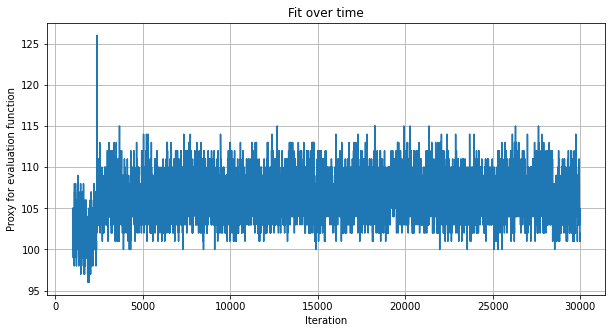

In [72]:
fig = plt.figure(figsize=(10,5))

start = 1000

y = error.total[start:]
x = start + np.arange(error.shape[0]-start)


plt.plot(x,y)
plt.grid()

plt.xlabel('Iteration')
plt.ylabel('Proxy for evaluation function')

plt.title('Fit over time')
plt.show()

In [1]:
## need to replace proxy fn with actual weight fn!